In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
df = pd.read_csv('candidate_variables.csv')
df.head()

,Recnum,Fraud,Dow_Risk,state_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,...,Card_Merchnum_desc_count_1_by_7,Card_Merchnum_desc_total_amount_1_by_7,Card_Merchnum_desc_count_1_by_14,Card_Merchnum_desc_total_amount_1_by_14,Card_Merchnum_desc_count_1_by_30,Card_Merchnum_desc_total_amount_1_by_30,Card_Merchnum_desc_count_1_by_60,Card_Merchnum_desc_total_amount_1_by_60,benford_Cardnum,benford_Merchnum
0,1,0,0.025994,0.007970,0.0,1,3.62,3.62,3.62,3.62,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000
1,2,0,0.025994,0.003304,0.0,1,31.42,31.42,31.42,31.42,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000894,1.000894
2,3,0,0.025994,0.017282,0.0,1,178.49,178.49,178.49,178.49,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000894,1.000894
3,4,0,0.025994,0.007970,0.0,1,3.62,3.62,3.62,3.62,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000
4,5,0,0.025994,0.007970,0.0,2,3.62,3.62,3.62,7.24,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000


In [3]:
df = df.set_index('Recnum') 
df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
goods = df[df['Fraud'] == 0]
bads = df[df['Fraud'] == 1]

In [4]:
# set num_filter to be about 20% of the original # variables
num_filter = 80

# set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then run it again with num_wrapper somewhat above this saturation point, not more than twice
num_wrapper = 30

# balance = 0
detect_rate = .03

In [5]:
num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2
num_vars

804

In [6]:
# if(balance != 0):
#     num_goods_desired = int(min(num_goods,num_bads*balance))
#     goods = goods.sample(n=num_goods_desired,random_state=1)
#     goods_keep = list(goods.index)
#     goods_keep.sort()

In [7]:
df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)

# 1. Run a filter to get 80 top variables

In [8]:
filter_score = pd.DataFrame(np.zeros((len(df_sampled.columns),2)))
filter_score.columns = ['variable','filter score']   

In [9]:
%%time

j = 0
for column in df_sampled:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1
    if j%100 == 0:
        print(str(j)+' completed')
print('A total of ' + str(j)+' completed!')

100 completed
200 completed
300 completed
400 completed
500 completed
600 completed
700 completed
800 completed
A total of 806 completed!
CPU times: user 5.37 s, sys: 0 ns, total: 5.37 s
Wall time: 5.36 s


In [10]:
filter_score

,variable,filter score
0,Fraud,1.000000
1,Dow_Risk,0.130764
2,state_risk,0.344286
3,Cardnum_day_since,0.291463
4,Cardnum_count_0,0.339691
...,...,...
801,Card_Merchnum_desc_count_1_by_60,0.076343
802,Card_Merchnum_desc_total_amount_1_by_60,0.077241
803,benford_Cardnum,0.422603
804,benford_Merchnum,0.302473


In [11]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score

,variable,filter score
0,Fraud,1.000000
419,card_zip3_total_7,0.696009
410,card_zip3_total_3,0.688061
227,card_zip_total_7,0.684517
428,card_zip3_total_14,0.681898
...,...,...
697,card_zip_count_0_by_60,0.057257
699,card_zip_count_1_by_7,0.055219
700,card_zip_total_amount_1_by_7,0.054645
723,zip3_count_0_by_7,0.048809


In [12]:
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
X = df_sampled.filter(vars_keep, axis=1)
Y = pd.DataFrame(df_sampled['Fraud'], index=df_sampled.index)
Y = Y.values

In [13]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [14]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


# 2. Run a wrapper to get 30 top variables

In [15]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [16]:
%%time

# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=5) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=10,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=10,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: user 11.5 s, sys: 27.2 s, total: 38.8 s
Wall time: 17min 1s


SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=5),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0xffff5b891040>)

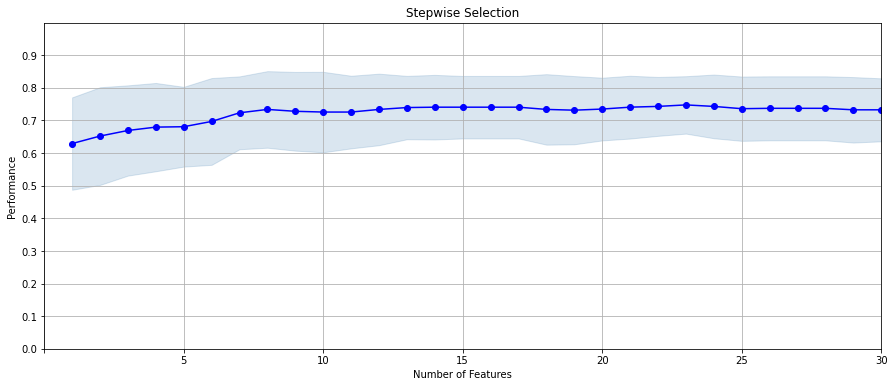

In [17]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
# plt.savefig('FS_fdr.png')
plt.show()

In [18]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [19]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[-1]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names']))[0]

In [20]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(0,)","[0.4367816091954023, 0.6091954022988506, 0.770...",0.62923,"(card_zip3_total_7,)",0.105193,0.141633,0.047211,1.0,card_zip3_total_7
2,"(0, 65)","[0.42528735632183906, 0.6666666666666666, 0.77...",0.652219,"(card_zip3_total_7, Merchnum_desc_total_1)",0.111197,0.149717,0.049906,2.0,Merchnum_desc_total_1
3,"(0, 49, 65)","[0.47126436781609193, 0.6781609195402298, 0.74...",0.669366,"(card_zip3_total_7, Card_Merchnum_desc_max_60,...",0.102786,0.138392,0.046131,3.0,Card_Merchnum_desc_max_60
4,"(0, 49, 65, 68)","[0.5977011494252874, 0.5747126436781609, 0.827...",0.679671,"(card_zip3_total_7, Card_Merchnum_desc_max_60,...",0.100531,0.135357,0.045119,4.0,merch_zip_total_3
5,"(0, 42, 49, 65, 68)","[0.47126436781609193, 0.6551724137931034, 0.75...",0.680887,"(card_zip3_total_7, Card_Merchdesc_total_60, C...",0.090816,0.122276,0.040759,5.0,Card_Merchdesc_total_60
6,"(0, 10, 42, 49, 65, 68)","[0.42528735632183906, 0.6551724137931034, 0.81...",0.69706,"(card_zip3_total_7, card_zip3_total_1, Card_Me...",0.098825,0.133059,0.044353,6.0,card_zip3_total_1
7,"(0, 10, 37, 42, 49, 65, 68)","[0.7816091954022989, 0.5632183908045977, 0.770...",0.723536,"(card_zip3_total_7, card_zip3_total_1, card_zi...",0.082973,0.111716,0.037239,7.0,card_zip_max_30
8,"(0, 10, 16, 37, 42, 49, 65, 68)","[0.7816091954022989, 0.5632183908045977, 0.827...",0.733921,"(card_zip3_total_7, card_zip3_total_1, card_zi...",0.087183,0.117385,0.039128,8.0,card_zip3_total_30
9,"(0, 10, 16, 37, 42, 49, 60, 65, 68)","[0.7816091954022989, 0.5862068965517241, 0.827...",0.728174,"(card_zip3_total_7, card_zip3_total_1, card_zi...",0.089616,0.12066,0.04022,9.0,card_zip3_total_0
10,"(0, 10, 16, 37, 42, 49, 60, 65, 66, 68)","[0.7816091954022989, 0.5862068965517241, 0.827...",0.725875,"(card_zip3_total_7, card_zip3_total_1, card_zi...",0.091587,0.123314,0.041105,10.0,card_zip_total_0


In [21]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
# vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1               card_zip3_total_7
2           Merchnum_desc_total_1
3       Card_Merchnum_desc_max_60
4               merch_zip_total_3
5         Card_Merchdesc_total_60
6               card_zip3_total_1
7                 card_zip_max_30
8              card_zip3_total_30
9               card_zip3_total_0
10               card_zip_total_0
11               card_merch_max_1
12             card_merch_total_0
13                 card_zip_max_1
14             card_zip3_total_60
15       Card_Merchnum_desc_max_7
16           Card_Merchdesc_max_1
17       Card_Merchnum_desc_max_1
18               Merchnum_total_3
19              card_merch_max_60
20              card_merch_max_14
21              card_zip_total_60
22    Card_Merchnum_desc_total_60
23      Card_Merchnum_desc_max_14
24               card_merch_max_7
25                card_zip_max_14
26                 card_zip_max_0
27           Card_Merchdesc_max_0
28       Card_Merchnum_desc_max_0
29    Card_Merchnum_desc_total_14
30        Card

In [22]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_zip3_total_7
Merchnum_desc_total_1
Card_Merchnum_desc_max_60
merch_zip_total_3
Card_Merchdesc_total_60


In [23]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score.head()

,filter score
variable,
card_zip3_total_7,0.696009
card_zip3_total_3,0.688061
card_zip_total_7,0.684517
card_zip3_total_14,0.681898
card_merch_total_7,0.681641


In [24]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
# vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted.head()

,wrapper order,variable,filter score
0,1,card_zip3_total_7,0.696009
1,2,Merchnum_desc_total_1,0.609987
2,3,Card_Merchnum_desc_max_60,0.639346
3,4,merch_zip_total_3,0.608792
4,5,Card_Merchdesc_total_60,0.645482


In [25]:
vars_keep_list.append('Recnum')
vars_keep_list.append('Fraud')
vars_keep_list

['card_zip3_total_7',
 'Merchnum_desc_total_1',
 'Card_Merchnum_desc_max_60',
 'merch_zip_total_3',
 'Card_Merchdesc_total_60',
 'card_zip3_total_1',
 'card_zip_max_30',
 'card_zip3_total_30',
 'card_zip3_total_0',
 'card_zip_total_0',
 'card_merch_max_1',
 'card_merch_total_0',
 'card_zip_max_1',
 'card_zip3_total_60',
 'Card_Merchnum_desc_max_7',
 'Card_Merchdesc_max_1',
 'Card_Merchnum_desc_max_1',
 'Merchnum_total_3',
 'card_merch_max_60',
 'card_merch_max_14',
 'card_zip_total_60',
 'Card_Merchnum_desc_total_60',
 'Card_Merchnum_desc_max_14',
 'card_merch_max_7',
 'card_zip_max_14',
 'card_zip_max_0',
 'Card_Merchdesc_max_0',
 'Card_Merchnum_desc_max_0',
 'Card_Merchnum_desc_total_14',
 'Card_Merchdesc_total_14',
 'Recnum',
 'Fraud']

In [26]:
df = pd.read_csv('candidate_variables.csv')
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(80983, 31)


In [27]:
df_keep.to_csv('vars_final.csv',index=False)

In [28]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:17:19.444417
